# 寵物品種辨識（Pet Breed Classification）\n\n本 Notebook 以 **每類 5 張圖片** 的小樣本資料，示範如何用 **ResNet18 Transfer Learning** 訓練可展示的品種辨識模型，並輸出評估圖表與可部署模型（TorchScript）。

## 0. 安裝套件（Colab）

In [7]:
!pip -q install torch torchvision scikit-learn matplotlib opencv-python-headless tqdm
import torch, torchvision
print('torch:', torch.__version__)
print('torchvision:', torchvision.__version__)

torch: 2.9.0+cu126
torchvision: 0.24.0+cu126


## 1. 準備資料\n\n請確認你的資料夾為：\n\n```
dataset/<class>/*.jpg
```\n\n例如：\n- dataset/Shiba Inu/xxx.jpg\n- dataset/Ragdoll/yyy.png\n\n接著我們自動切成 train/val/test（3/1/1）。

In [8]:
import os, random, shutil
from pathlib import Path

SRC_ROOT = Path("/content/Pet-Breed-Classifier/dataset")
DST_ROOT = Path("/content/Pet-Breed-Classifier/data_split")
SEED = 42
RATIOS = (3,1,1)  # train/val/test = 3/1/1

random.seed(SEED)

assert SRC_ROOT.exists(), f"找不到資料夾：{SRC_ROOT.resolve()}"
classes = [p for p in SRC_ROOT.iterdir() if p.is_dir()]
print("Classes:", [c.name for c in classes])

# 建立輸出結構
for split in ["train","val","test"]:
    for cls in classes:
        (DST_ROOT / split / cls.name).mkdir(parents=True, exist_ok=True)

# 分割並複製
for cls in classes:
    files = [p for p in cls.iterdir() if p.is_file()]
    if len(files) < sum(RATIOS):
        raise ValueError(f"類別 {cls.name} 圖片不足：{len(files)} < {sum(RATIOS)}")
    random.shuffle(files)

    train_files = files[:RATIOS[0]]
    val_files   = files[RATIOS[0]:RATIOS[0]+RATIOS[1]]
    test_files  = files[RATIOS[0]+RATIOS[1]:RATIOS[0]+RATIOS[1]+RATIOS[2]]

    for p in train_files:
        shutil.copy2(p, DST_ROOT/"train"/cls.name/p.name)
    for p in val_files:
        shutil.copy2(p, DST_ROOT/"val"/cls.name/p.name)
    for p in test_files:
        shutil.copy2(p, DST_ROOT/"test"/cls.name/p.name)

print("[OK] 分割完成 ->", DST_ROOT.resolve())


Classes: ['Shiba Inu', 'American Shorthair', 'Husky', 'Ragdoll', 'Maine Coon', 'Labrador', 'Golden Retriever', 'British Shorthair']
[OK] 分割完成 -> /content/Pet-Breed-Classifier/data_split


## 2. DataLoader 與資料增強（小樣本關鍵）

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

IMG_SIZE = 224
BATCH_SIZE = 8  # 小資料集不需要太大
NUM_WORKERS = 2

train_tfm = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

eval_tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

train_ds = datasets.ImageFolder("/content/Pet-Breed-Classifier/data_split/train", transform=train_tfm)
val_ds   = datasets.ImageFolder("/content/Pet-Breed-Classifier/data_split/val", transform=eval_tfm)
test_ds  = datasets.ImageFolder("/content/Pet-Breed-Classifier/data_split/test", transform=eval_tfm)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

class_names = train_ds.classes
num_classes = len(class_names)
print("num_classes =", num_classes)
print("classes =", class_names)


num_classes = 8
classes = ['American Shorthair', 'British Shorthair', 'Golden Retriever', 'Husky', 'Labrador', 'Maine Coon', 'Ragdoll', 'Shiba Inu']


## 3. 建立模型（ResNet18 Transfer Learning）\n\n策略：\n1) 先凍結 backbone，只訓練最後 fc\n2) 若需要再微調 layer4（較保守，小 LR）

In [19]:
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# ✅ MobileNetV2 (ImageNet pretrained)
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

# 凍結 feature extractor（小樣本避免 overfit）
for p in model.features.parameters():
    p.requires_grad = False

# 替換分類頭
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[1].parameters(), lr=1e-3)

model


device: cpu
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 55.8MB/s]


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

## 4. 訓練迴圈（含 Early Stopping）

In [20]:
from tqdm import tqdm
import numpy as np

def run_epoch(model, loader, train: bool):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        if train:
            optimizer.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(train):
            logits = model(x)
            loss = criterion(logits, y)

            if train:
                loss.backward()
                optimizer.step()

        total_loss += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += x.size(0)

    return total_loss/total, correct/total

EPOCHS = 30
patience = 5
best_val = -1
best_state = None
wait = 0

history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(model, train_loader, train=True)
    va_loss, va_acc = run_epoch(model, val_loader, train=False)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss)
    history["val_acc"].append(va_acc)

    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.3f} | val loss {va_loss:.4f} acc {va_acc:.3f}")

    if va_acc > best_val:
        best_val = va_acc
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

# 載入最佳模型
model.load_state_dict(best_state)
print("Best val acc =", best_val)


Epoch 01 | train loss 2.2414 acc 0.081 | val loss 1.7164 acc 0.522
Epoch 02 | train loss 1.7058 acc 0.405 | val loss 1.4230 acc 0.565
Epoch 03 | train loss 1.4142 acc 0.676 | val loss 1.1056 acc 0.870
Epoch 04 | train loss 1.0802 acc 0.838 | val loss 0.8560 acc 0.913
Epoch 05 | train loss 0.8225 acc 0.946 | val loss 0.6919 acc 0.913
Epoch 06 | train loss 0.7936 acc 0.892 | val loss 0.5879 acc 0.957
Epoch 07 | train loss 0.6496 acc 0.973 | val loss 0.4930 acc 0.957
Epoch 08 | train loss 0.5110 acc 0.973 | val loss 0.4285 acc 0.957
Epoch 09 | train loss 0.4194 acc 1.000 | val loss 0.3753 acc 0.957
Epoch 10 | train loss 0.5003 acc 0.946 | val loss 0.3279 acc 0.957
Epoch 11 | train loss 0.3099 acc 0.973 | val loss 0.2795 acc 0.957
Early stopping triggered.
Best val acc = 0.9565217391304348


## 5. 繪製 Learning Curves

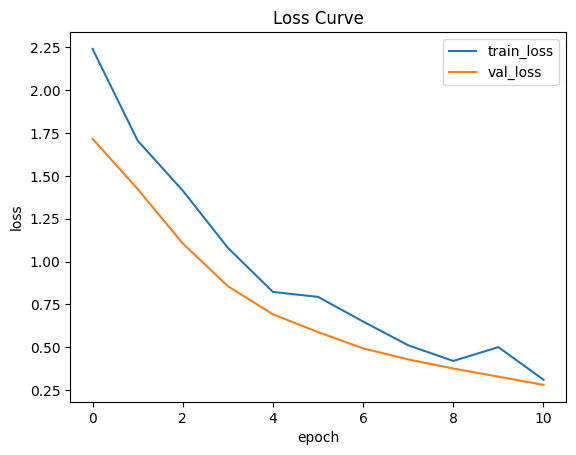

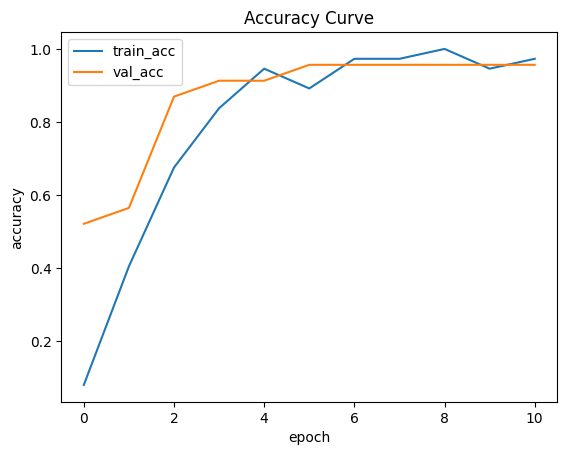

In [21]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss Curve")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

plt.figure()
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.legend()
plt.title("Accuracy Curve")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()


## 6. 測試集評估：Confusion Matrix + Classification Report

In [22]:
from sklearn.metrics import confusion_matrix, classification_report

model.eval()
all_y = []
all_pred = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x)
        pred = logits.argmax(dim=1).cpu().numpy()
        all_pred.extend(pred.tolist())
        all_y.extend(y.numpy().tolist())

cm = confusion_matrix(all_y, all_pred)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:")
print(classification_report(all_y, all_pred, target_names=class_names))


Confusion Matrix:
 [[3 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 1 0 1 0 0 0]
 [0 0 0 3 0 0 0 0]
 [0 0 0 0 2 0 0 0]
 [0 0 0 0 0 3 0 0]
 [0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 3]]

Classification Report:
                    precision    recall  f1-score   support

American Shorthair       1.00      1.00      1.00         3
 British Shorthair       1.00      1.00      1.00         1
  Golden Retriever       1.00      0.50      0.67         2
             Husky       1.00      1.00      1.00         3
          Labrador       0.67      1.00      0.80         2
        Maine Coon       1.00      1.00      1.00         3
           Ragdoll       1.00      1.00      1.00         3
         Shiba Inu       1.00      1.00      1.00         3

          accuracy                           0.95        20
         macro avg       0.96      0.94      0.93        20
      weighted avg       0.97      0.95      0.95        20



## 7. 匯出模型給 Streamlit（TorchScript）

In [26]:
import os, json
import torch

EXPORT_DIR = "/content/Pet-Breed-Classifier/exports"
os.makedirs(EXPORT_DIR, exist_ok=True)

example = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)

# ✅ TorchScript（trace）
traced = torch.jit.trace(model, example)
model_path = os.path.join(EXPORT_DIR, "model_mobilenetv2.pt")
traced.save(model_path)

# 類別名稱
class_path = os.path.join(EXPORT_DIR, "class_names.json")
with open(class_path, "w", encoding="utf-8") as f:
    json.dump(class_names, f, ensure_ascii=False, indent=2)


torch.save(model.state_dict(), "/content/Pet-Breed-Classifier/exports/model_mobilenetv2.pth")
print("Saved: exports/model_mobilenetv2.pth")

print("Saved:", model_path)
print("Saved:", class_path)


Saved: exports/model_mobilenetv2.pth
Saved: /content/Pet-Breed-Classifier/exports/model_mobilenetv2.pt
Saved: /content/Pet-Breed-Classifier/exports/class_names.json


## 8. 單張圖片快速測試（Top-3）

In [24]:
from PIL import Image
import numpy as np

def predict_image(img_path, topk=3):
    img = Image.open(img_path).convert("RGB")
    x = eval_tfm(img).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1).cpu().numpy().squeeze()
    idx = probs.argsort()[::-1][:topk]
    return [(class_names[i], float(probs[i])) for i in idx]

# 找一張 test 圖片
sample = None
for root, _, files in os.walk("/content/Pet-Breed-Classifier/data_split/test"):
    for fn in files:
        sample = os.path.join(root, fn)
        break
    if sample:
        break

print("Sample:", sample)
print(predict_image(sample, topk=3))


Sample: /content/Pet-Breed-Classifier/data_split/test/Shiba Inu/Shiba Inu4.jpg
[('Shiba Inu', 0.5177077651023865), ('Husky', 0.15885165333747864), ('Labrador', 0.14491327106952667)]
